# Normalisation and prediction


What is the proper data pre-processing approach for GPR?
Should we normalise the data (features, target)? 
We will focus the target normalisation in this notebook.

Define the following steps on each replicate:  
- A. In each round, substract the mean of every data points by the reference AVERAGE, and then add 100 (to make the values positive).  
- B. Take log (base e) transformation for each data points.  
- C. Apply z-score normalisation.  
    - C.1 on all data, so that the mean and variance of each replicate of all data is zero and one after normalisation. 
    - C.2 on each round, so that the mean and variance of each replicate of data in each round is zero and one after normalisation. 
- D. Apply min-max normalisation.
    - D.1 on all data
    - D.2 on each round
- E. Apply ratio normalisation. In each round, each data points is devided by the mean of refernce AVERAGE, so that in each round, the reference labels are almost 1. 


We compare the following approaches:
- A+B+C.1
- A+B+C.2
- A

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from collections import defaultdict
import math
import json
from scipy.stats import spearmanr

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import PairwiseKernel, DotProduct, RBF 
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.model_selection import KFold
from sklearn_extra.cluster import KMedoids

from codes.embedding import Embedding
from codes.environment import Rewards_env
from codes.ucb import GPUCB, Random
from codes.evaluations import evaluate, plot_eva
from codes.regression import *
from codes.kernels_for_GPK import *
from codes.batch_ucb import *

from ipywidgets import IntProgress
from IPython.display import display
import warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis
['/home/admin-u6015325/ownCloud/git/SynbioML/notebooks/result_analysis', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles', '/home/admin-u6015325/.vscode/extensions/ms-toolsai.jupyter-2021.5.745244803/pythonFiles/lib/python', '/home/admin-u6015325/anaconda3/lib/python37.zip', '/home/admin-u6015325/anaconda3/lib/python3.7', '/home/admin-u6015325/anaconda3/lib/python3.7/lib-dynload', '', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/strkernel-0.2-py3.7.egg', '/home/admin-u6015325/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/home/admin-u6015325/.ipython', '/home/admin-u6015325/ownCloud/git/SynbioML']


In [2]:
norm_method = 'mean'
log_flag = 'True'
to_design_round = '_Round4'

folder_path = '../../data/pipeline_data/'

Path_raw = folder_path + 'Results_n.csv'
# normalisation over round
Path_normalised = folder_path + 'Results_abc1.csv'
# normalasation over all data 
Path_RNF = folder_path + 'Results_abc2.csv'

df_raw = pd.read_csv(Path_raw)
df_normalised = pd.read_csv(Path_normalised)
df_RNF = pd.read_csv(Path_RNF)


In [3]:
def hist(df, title = 'Hist'):
    df_bandits = df.loc[df_raw['Group'].isin(['Bandit-0', 'Bandit-1', 'Bandit-2', 'Bandit-3'])]
    sns.histplot(data = df_bandits, x = 'AVERAGE', hue = 'Group', kde=True)
    plt.title(title)
    print('mean:')
    print(df_bandits.groupby('Group').mean())
    print('0.9 quantile')
    print(df_bandits.groupby('Group').quantile(0.9))

# Shift of Gaussians?

If you ask we to picture how the TIR in different rounds distributed, here's the picture in my mind: assume for each round, we have a Gaussian distribution of TIRs in each round (well, do not ask me why Gaussians, that's how we usually imagine a distribution of something), where the means of Gaussians increase with round increases and the STDs are similar for the first three round and smaller for the last round (since we selected a smaller exploration rate for the last round).

To confirm whether my imagine is correct, here it is, I draw the histogram of each round. For presentation, I only show bandits results. But notice that the Round 0 includes other groups as well (random, 1by1, etc.). 

mean:
          Round       Rep1       Rep2       Rep3       Rep4       Rep5  \
Group                                                                    
Bandit-0      0  27.195162  19.552720  36.276470  18.541068  18.651241   
Bandit-1      1  25.376617  20.452336  19.007654  31.365680  33.609261   
Bandit-2      2  34.541806  33.695261  32.305718  35.800692  30.943444   
Bandit-3      3  39.976976  35.293723  35.071154  34.413175  35.351209   

               Rep6    AVERAGE       STD  
Group                                     
Bandit-0  15.577162  22.632304  8.606778  
Bandit-1  30.769370  26.763486  8.073239  
Bandit-2  28.217814  32.584123  6.996816  
Bandit-3  38.053146  36.359897  5.245114  
0.9 quantile
          Round       Rep1       Rep2       Rep3       Rep4       Rep5  \
Group                                                                    
Bandit-0    0.0  42.102985  29.784481  55.792460  29.789616  29.116593   
Bandit-1    1.0  45.105316  34.101955  30.025601  59.240

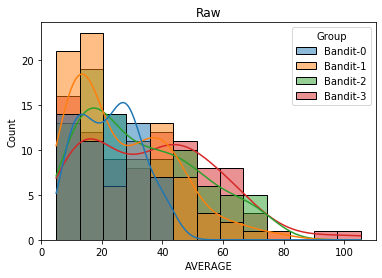

In [4]:
hist(df_raw, 'Raw')

The above plot shows the raw data, before any preprocessing. It's good to star at the raw data and understand it before we really make it as the way we want. 

- So they do not looks like Gaussians, but more like a mixture of two absolute Gaussians. 
- And they do have the "shift" of means and sharp STD for the last group as we imagined, that's good!
- It is even more interesting to look at the two modes of each round seperately. The modes with high AVERAGE increases along rounds; the modes with low AVERAGE are almost the same for each round, where the Bandit-3 has a much smaller count. Again, that's because we chose to use a smaller exploration rate. 

In the following, we show approach A., that is only apply mean shift by reference AVERAGE in each round. 

mean:
          Round       Rep1       Rep2       Rep3       Rep4       Rep5  \
Group                                                                    
Bandit-0      0  61.642593  54.000150  70.723901  52.988498  53.098672   
Bandit-1      1  53.353770  48.429490  46.984807  59.342834  61.586414   
Bandit-2      2  59.943767  59.097223  57.707680  61.202654  56.345406   
Bandit-3      3  61.296336  56.613083  56.390514  55.732536  56.670570   

               Rep6    AVERAGE       STD  
Group                                     
Bandit-0  50.024592  57.079734  8.606778  
Bandit-1  58.746524  54.740640  8.073239  
Bandit-2  53.619776  57.986084  6.996816  
Bandit-3  59.372506  57.679257  5.245114  
0.9 quantile
          Round       Rep1       Rep2       Rep3       Rep4       Rep5  \
Group                                                                    
Bandit-0    0.0  76.550415  64.231912  90.239891  64.237047  63.564024   
Bandit-1    1.0  73.082469  62.079108  58.002754  87.217

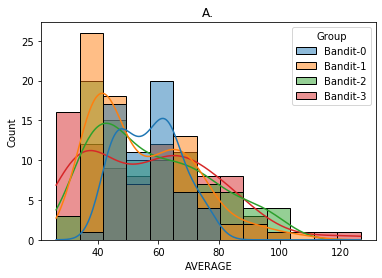

In [5]:
path_a = folder_path + 'Results_a.csv'

df_a = pd.read_csv(path_a)

hist(df_a, 'A.')

Ok, now let's have a look at how normalisation changes the distributions. More importantly, whether those changes accord to out goal?

mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0 -0.162664 -0.189317 -0.260353 -0.244273 -0.127305 -0.325771   
Bandit-1      1 -0.022638 -0.025114 -0.031234 -0.021697 -0.020408 -0.025057   
Bandit-2      2 -0.056047 -0.055716 -0.051224 -0.052630 -0.063401 -0.052195   
Bandit-3      3 -0.045590 -0.052606 -0.048212 -0.049720 -0.049544 -0.053295   

           AVERAGE       STD  
Group                         
Bandit-0 -0.218281  0.327279  
Bandit-1 -0.024358  0.288821  
Bandit-2 -0.055202  0.281543  
Bandit-3 -0.049828  0.233877  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.807362  0.858740  0.819015  0.891459  1.018791  0.699172   
Bandit-1    1.0  1.183677  1.120289  0.996730  1.254452  1.170948  1.139915   
Band

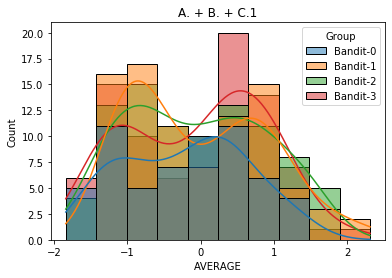

In [6]:
hist(df_normalised, 'A. + B. + C.1')

The above plot is A+ B+ C.1, i.e. z-score normalisation over rounds. 
Now TIRs are still two-mode Gaussians, but with zerom-mean and unit-variance (well, not exactly, since we actually perform normalisation for each replicates). They lose the pattern of Gaussian mean shifts and STD changes. 

mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0  0.093349 -0.004811  0.420417 -0.167840 -0.124602 -0.289818   
Bandit-1      1 -0.459492 -0.406161 -0.717811  0.041959  0.174562  0.104278   
Bandit-2      2 -0.008277  0.090447 -0.238754  0.071343 -0.101943 -0.168083   
Bandit-3      3 -0.105891 -0.059482 -0.338525 -0.202359 -0.117276  0.084325   

           AVERAGE       STD  
Group                         
Bandit-0 -0.012217  0.331121  
Bandit-1 -0.210444  0.497915  
Bandit-2 -0.059211  0.392745  
Bandit-3 -0.123201  0.358495  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.886391  0.594911  1.189286  0.464709  0.477665  0.341929   
Bandit-1    1.0  0.731249  0.485187 -0.056149  1.400493  1.547096  1.439625   
Band

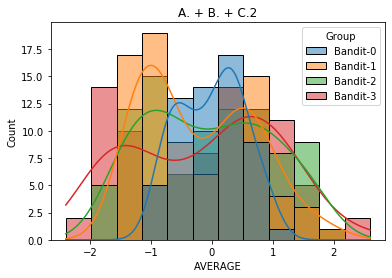

In [7]:
hist(df_RNF, 'A. + B. + C.2')

How about min-max normalsiation? 

mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0  0.544369  0.508879  0.619535  0.487007  0.458235  0.405090   
Bandit-1      1  0.443109  0.435788  0.387387  0.526165  0.518418  0.470451   
Bandit-2      2  0.525755  0.526227  0.485094  0.531650  0.462793  0.425280   
Bandit-3      3  0.507876  0.498923  0.464745  0.480564  0.459709  0.467142   

           AVERAGE       STD  
Group                         
Bandit-0  0.503852  0.084106  
Bandit-1  0.463553  0.082915  
Bandit-2  0.492800  0.082853  
Bandit-3  0.479826  0.061496  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.689624  0.618097  0.776350  0.605070  0.579394  0.509866   
Bandit-1    1.0  0.661208  0.598114  0.522337  0.779731  0.794533  0.691922   
Band

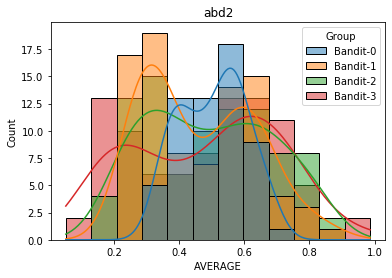

In [8]:
path_abd2 = folder_path + 'Results_abd2.csv'

df_abd2 = pd.read_csv(path_abd2)

hist(df_abd2, 'abd2')

mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0  0.360012  0.313551  0.431263  0.289843  0.281625  0.219082   
Bandit-1      1  0.279061  0.258326  0.215049  0.349797  0.367784  0.293127   
Bandit-2      2  0.343421  0.364082  0.312712  0.367345  0.314582  0.249604   
Bandit-3      3  0.356631  0.339455  0.300715  0.315733  0.317883  0.298441   

           AVERAGE       STD  
Group                         
Bandit-0  0.315896  0.081369  
Bandit-1  0.293857  0.077103  
Bandit-2  0.325291  0.076018  
Bandit-3  0.321476  0.051395  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.505607  0.414985  0.609014  0.395974  0.387859  0.301049   
Bandit-1    1.0  0.471738  0.393643  0.315400  0.612797  0.650301  0.493514   
Band

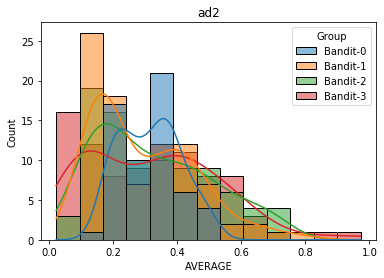

In [9]:
path_ad2 = folder_path + 'Results_ad2.csv'

df_ad2 = pd.read_csv(path_ad2)

hist(df_ad2, 'ad2')

The above plot is for A+B+C.2, i.e. z-score normalisation over all the data. 
You might also spot that Bandit-3 has a wider spread compared with other groups, for both tiles. The reason is that Bandit-3 used to have a smaller STD, to achieve a unit variance, Bandit-3 needs to spread wider than other groups. 


## Doubts:


So I think my question is actually, how to normalise when data is skewed?

Wait, I am now confused, why do we want to do z-score normalisation at all, GP seems to have no assumption for labels: for each x, it assumes y is Gaussian distributed. But is there also a Gaussian assumption for all labels for different x? So if it is true, then we do not need to do the overall normalisation at all, but actually, we should try to normalise replicates for each data point, so that they are all under the same Gaussian noise distribution. 

# Prediction

Now we show the prediction with raw data and the above two kinds of normalisation strategies. 

In [10]:
# copy from the pipeline for recommending round 2 seq

rec_size = 90
l = 6
s = 1
beta = 0
alpha = 2
sigma_0 = 1
kernel_name = 'WD_Kernel_Shift'
embedding = 'label'
kernel_norm_flag = True
centering_flag = True
unit_norm_flag = True

In [11]:
def pred(df):

    train_df = df[df['Round']!= 3]
    test_df = df[df['Round'] == 3]

    # train on train_df and test on test_df

    top_n = Top_n_ucb(
        train_df, kernel_name=kernel_name, l=l, s=s, sigma_0=sigma_0,
        embedding=embedding, alpha=alpha, rec_size=rec_size, beta=beta, 
        kernel_norm_flag=kernel_norm_flag, 
        centering_flag = centering_flag,    
        unit_norm_flag=unit_norm_flag,
        df_design= test_df)

    top_n.prediction()

    # write prediction to df_design
    # AVERAGE: true TIR; pred mean/std: predictions
    df_design = top_n.df_design

    
    spearman_cor = spearmanr(np.asarray(df_design['AVERAGE']), np.asarray(df_design['pred mean']))
    print('spearman cor: ', spearman_cor)

    # df_design_sorted_ave = df_raw.sort_values('pred mean', ascending=False).head(10)
    # spearmanr(np.asarray(df_design_sorted_ave['AVERAGE']), np.asarray(df_design_sorted_ave['pred mean']))
    threshold = 1.0
    xlims = [test_df['AVERAGE'].min(), test_df['AVERAGE'].max()]
    ylims = [df_design['pred mean'].min(), df_design['pred mean'].max()]
    # xlims = [-2, 2]
    # ylims = [0.5, 1.3]

    cmap = sns.cubehelix_palette(as_cmap=True)

    plt.scatter(test_df['AVERAGE'], df_design['pred mean'], c = df_design['pred std'], cmap = cmap)
    plt.fill_between([xlims[0], threshold], y1 = [threshold], y2= [ylims[-1]], color = 'r', alpha = 0.05)
    plt.fill_between([threshold, xlims[1]], y1 = [ylims[0]], y2= [threshold], color = 'r', alpha = 0.05)
    plt.fill_between([xlims[0], threshold], y1 = [ylims[0]], y2= [threshold], color = 'g', alpha = 0.05)
    plt.fill_between([threshold, xlims[-1]], y1 = [threshold], y2= [ylims[1]], color = 'g', alpha = 0.05)
    plt.colorbar()
    plt.xlim(xlims)
    plt.ylim(ylims)
    plt.xlabel('AVERAGE TIR')
    plt.ylabel('Pred TIR')
    plt.title('Round 3 Prediction')
    plt.plot(xlims, [threshold, threshold], color = 'orange')
    plt.plot([threshold, threshold],ylims, color = 'orange')

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

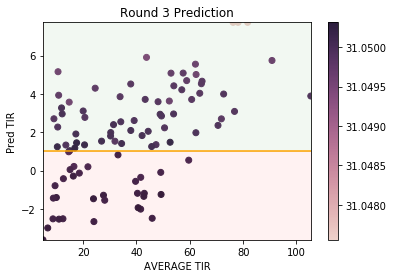

In [12]:
pred(df_raw)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

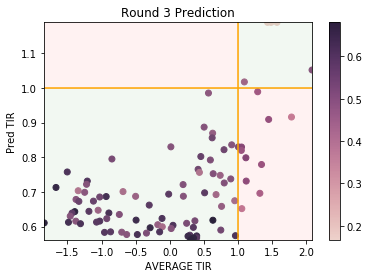

In [13]:
pred(df_normalised)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

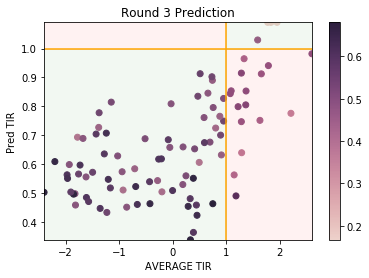

In [14]:
pred(df_RNF)

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

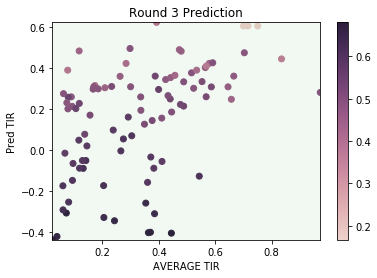

In [15]:
pred(df_ad2)

mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0 -0.164109 -0.277666  0.183990 -0.487207 -0.417170 -0.630752   
Bandit-1      1 -0.403500 -0.292274 -0.742395  0.068941  0.163934  0.142111   
Bandit-2      2  0.244095  0.182012 -0.107375  0.193411  0.046316  0.059205   
Bandit-3      3  0.250911  0.279952  0.012940  0.185400  0.282284  0.482685   

           AVERAGE       STD  
Group                         
Bandit-0 -0.298819  0.432346  
Bandit-1 -0.177197  0.546826  
Bandit-2  0.102944  0.423247  
Bandit-3  0.249029  0.346284  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.639784  0.435030  0.960398  0.344678  0.347404  0.188789   
Bandit-1    1.0  0.737736  0.611309  0.120209  1.259724  1.322862  1.275863   
Band

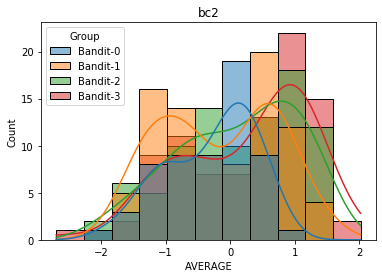

In [16]:
path_bc2 = folder_path + 'Results_bc2.csv'

df_bc2 = pd.read_csv(path_bc2)

hist(df_bc2, 'bc2')

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

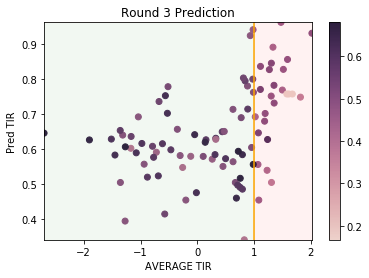

In [17]:
pred(df_bc2)

mean:
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0      0 -0.303725 -0.422770  0.097739 -0.540280 -0.512398 -0.650107   
Bandit-1      1 -0.404008 -0.374305 -0.756040  0.085367  0.240916  0.157688   
Bandit-2      2  0.101404  0.339128 -0.098577  0.301729  0.106660  0.022017   
Bandit-3      3  0.401124  0.425242  0.038147  0.234039  0.328643  0.544979   

           AVERAGE       STD  
Group                         
Bandit-0 -0.388590  0.342329  
Bandit-1 -0.175064  0.476217  
Bandit-2  0.128727  0.354263  
Bandit-3  0.328696  0.312936  
0.9 quantile
          Round      Rep1      Rep2      Rep3      Rep4      Rep5      Rep6  \
Group                                                                         
Bandit-0    0.0  0.518362  0.128443  1.062619  0.008479  0.014656 -0.136727   
Bandit-1    1.0  0.683925  0.361038 -0.211307  1.445228  1.642559  1.412765   
Band

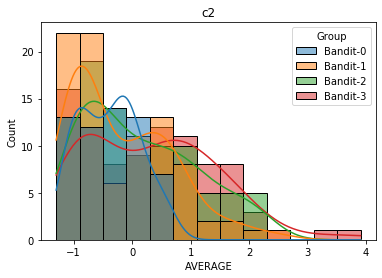

In [18]:
path_c2 = folder_path + 'Results_c2.csv'

df_c2 = pd.read_csv(path_c2)

hist(df_c2, 'c2')

/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_known['train_test'] = 'Train'
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_design['RBS6'] = df_design['RBS'].str[7:13]
/home/admin-u6015325/ownCloud/git/SynbioML/codes/batch_ucb.py:144: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = v

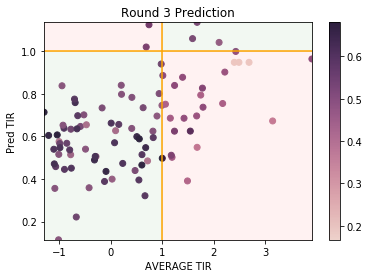

In [19]:
pred(df_c2)